# **Import Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from tensorflow.keras.optimizers import Adam, Nadam
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Persiapan Data**

# **4.3.1 Penggabungan Dataset**

In [ ]:
# Menggabungkan Data
datapath = '/content/drive/MyDrive/Colab Notebooks/Skripsi/Data Asli'
df = pd.DataFrame(columns=['TANGGAL', 'TAVG', 'RH_AVG', 'RR', 'FF_AVG', 'DDD_CAR'])

# Menelusuri semua folder dan subfolder
for path, subdirs, files in os.walk(datapath):
    for name in files:
        if name.endswith('.xlsx'):
            file_path = os.path.join(path, name)

            try:
                # Baca file Excel tanpa header
                raw_data = pd.read_excel(file_path, header=None)
                raw_data.columns = ['TANGGAL', 'TAVG', 'RH_AVG', 'RR', 'FF_AVG', 'DDD_CAR']

                df = pd.concat([df, raw_data], ignore_index=True)

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Konversi kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y', errors='coerce')
df = df.dropna(subset=['TANGGAL'])
df = df.sort_values(by='TANGGAL').reset_index(drop=True)

output_file = '/content/drive/MyDrive/Colab Notebooks/Skripsi/Data/Cuaca_Pekanbaru.xlsx'
df.to_excel (output_file, index=False)
print(f"Data berhasil disimpan")

Data berhasil disimpan


**Baca Data**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Skripsi/Data/Cuaca_Pekanbaru.xlsx')
df

,TANGGAL,TAVG,RH_AVG,RR,FF_AVG,DDD_CAR
0,2015-01-01,25.4,86,24,1,N
1,2015-01-02,25.9,88,0,1,N
2,2015-01-03,26.1,84,1.8,1,N
3,2015-01-04,26.3,84,0,1,N
4,2015-01-05,26.2,85,0.5,1,N
...,...,...,...,...,...,...
3941,2024-12-27,28.3,81,8888,1,C
3942,2024-12-28,27.5,83,4,2,NE
3943,2024-12-29,27.7,84,8.2,2,C
3944,2024-12-30,25.9,87,52.7,2,C


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3946 entries, 0 to 3945
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  3946 non-null   datetime64[ns]
 1   TAVG     3946 non-null   object        
 2   RH_AVG   3946 non-null   object        
 3   RR       3946 non-null   object        
 4   FF_AVG   3946 non-null   object        
 5   DDD_CAR  3946 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 185.1+ KB


# **4.3.2 Menghapus duplikat**

In [ ]:
# Memeriksa data duplikat
df.duplicated().sum()

np.int64(306)

In [ ]:
# Menghapus data duplikat berdasarkan tanggal
df = df.drop_duplicates(subset=['TANGGAL'], keep='first')
df = df.sort_values(by='TANGGAL').reset_index(drop=True)
df

,TANGGAL,TAVG,RH_AVG,RR,FF_AVG,DDD_CAR
0,2015-01-01,25.4,86,24,1,N
1,2015-01-02,25.9,88,0,1,N
2,2015-01-03,26.1,84,1.8,1,N
3,2015-01-04,26.3,84,0,1,N
4,2015-01-05,26.2,85,0.5,1,N
...,...,...,...,...,...,...
3635,2024-12-27,28.3,81,8888,1,C
3636,2024-12-28,27.5,83,4,2,NE
3637,2024-12-29,27.7,84,8.2,2,C
3638,2024-12-30,25.9,87,52.7,2,C


In [ ]:
# Mengubah tipe data kategori ke numerik
df[['TAVG', 'RH_AVG', 'FF_AVG', 'RR']] = df[
    ['TAVG', 'RH_AVG', 'FF_AVG', 'RR']].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Melihat Nilai Tidak terukur
data_nonvalid = (df == 8888).sum()
print("Jumlah nilai tidak terukur di setiap kolom:\n", data_nonvalid)

Jumlah nilai tidak terukur di setiap kolom:
 TANGGAL      0
TAVG         0
RH_AVG       0
RR         313
FF_AVG       0
DDD_CAR      0
dtype: int64


# **4.3.3 Perbaikan Data**

In [ ]:
# Mengganti nilai tidak terukur (8888) menjadi  NaN
df['RR'] = df['RR'].replace({8888: np.nan})

In [ ]:
# Melihat nilai kategori pada DDD_CAR
unique_ddd_car = df['DDD_CAR'].unique()
print(df['DDD_CAR'].unique())

['N ' 'S ' 'C ' 'NW' 'SE' '-' 'NE' 'E ' 'W ' 'SW' 'C' 'E' 'S' 'N']


In [ ]:
# Membersihkan nilai kategori
df['DDD_CAR'] = df['DDD_CAR'].replace('-', np.nan)
df['DDD_CAR'] = [str(item).strip() if not pd.isna(item) else item
                 for item in df['DDD_CAR']]

# **4.3.4 Imputasi Nilai Hilang**

In [ ]:
df.isnull().sum().sum()

np.int64(811)

In [ ]:
df.ffill(inplace=True)

# **4.3.5 Transformasi Data**

In [ ]:
# Menggunakan label encode untuk mengubah fitur kategori menjadi numerik
label_encoder = LabelEncoder()
df['DDD_CAR'] = label_encoder.fit_transform(df['DDD_CAR'].astype(str))

In [ ]:
print("Mapping Label Encoding:")
mapping = dict(zip(df['DDD_CAR'], label_encoder.inverse_transform(df['DDD_CAR'])))
mapping

Mapping Label Encoding:


{2: 'N', 5: 'S', 0: 'C', 4: 'NW', 6: 'SE', 3: 'NE', 1: 'E', 8: 'W', 7: 'SW'}

In [ ]:
# Memeriksa Nilai Hilang
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df = df.sort_values(by='TANGGAL').reset_index(drop=True)
df

,TANGGAL,TAVG,RH_AVG,RR,FF_AVG,DDD_CAR
0,2015-01-01,25.4,86.0,24.0,1.0,2
1,2015-01-02,25.9,88.0,0.0,1.0,2
2,2015-01-03,26.1,84.0,1.8,1.0,2
3,2015-01-04,26.3,84.0,0.0,1.0,2
4,2015-01-05,26.2,85.0,0.5,1.0,2
...,...,...,...,...,...,...
3635,2024-12-27,28.3,81.0,1.0,1.0,0
3636,2024-12-28,27.5,83.0,4.0,2.0,3
3637,2024-12-29,27.7,84.0,8.2,2.0,0
3638,2024-12-30,25.9,87.0,52.7,2.0,0


In [ ]:
# output_file = '/content/drive/MyDrive/Colab Notebooks/Skripsi/Data/Data Akhir.xlsx'
# df.to_excel (output_file, index=False)
# print(f"Data berhasil disimpan")

# **4.3.6 Data Scaling**

In [ ]:
X = df[['TAVG', 'RH_AVG','FF_AVG', 'DDD_CAR']]
y = df['RR']

In [ ]:
scaler_fitur = MinMaxScaler()
scaler_target = MinMaxScaler()
X_scaled = scaler_fitur.fit_transform(X)
y_scaled = scaler_target.fit_transform(y.values.reshape(-1,1))

In [ ]:
# Buat DataFrame dari X_scaled
df_x_scaled = pd.DataFrame(X_scaled, columns=['TAVG_scaled', 'RH_AVG_scaled', 'FF_AVG_scaled', 'DDD_CAR_scaled'])
print("Data X Scaled:")
df_x_scaled


Data X Scaled:


,TAVG_scaled,RH_AVG_scaled,FF_AVG_scaled,DDD_CAR_scaled
0,0.215054,0.714286,0.25,0.250
1,0.268817,0.755102,0.25,0.250
2,0.290323,0.673469,0.25,0.250
3,0.311828,0.673469,0.25,0.250
4,0.301075,0.693878,0.25,0.250
...,...,...,...,...
3635,0.526882,0.612245,0.25,0.000
3636,0.440860,0.653061,0.50,0.375
3637,0.462366,0.673469,0.50,0.000
3638,0.268817,0.734694,0.50,0.000


In [ ]:
# Buat DataFrame dari y_scaled
df_y_scaled = pd.DataFrame(y_scaled, columns=['RR_scaled'])
print("\nData Y Scaled:")
df_y_scaled


Data Y Scaled:


,RR_scaled
0,0.119107
1,0.000000
2,0.008933
3,0.000000
4,0.002481
...,...
3635,0.004963
3636,0.019851
3637,0.040695
3638,0.261538


In [ ]:
# output_file_y = '/content/drive/MyDrive/Colab Notebooks/Skripsi/Data/y_scaled.xlsx'
# df_y_scaled.to_excel(output_file_y, index=False)
# print(f"Data y_scaled berhasil disimpan")

Data y_scaled berhasil disimpan


# **4.3.7 Sliding Window**

In [ ]:
def create_sequences(X_scaled, y_scaled, timesteps):
    X = []
    y = []
    for i in range(len(X_scaled) - timesteps):
        X.append(X_scaled[i:i + timesteps])
        y.append(y_scaled[i + timesteps])
    return np.array(X), np.array(y)

In [ ]:
timesteps = 7
X, y = create_sequences(X_scaled, y_scaled, timesteps)

print(f"Jumlah sampel dengan timestep 7: {X.shape[0]}")

Jumlah sampel dengan timestep 7: 3633


# **4.3.8 Pembagian Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (2906, 7, 4)
Shape y_train: (2906, 1)
Shape X_test: (727, 7, 4)
Shape y_test: (727, 1)


In [ ]:
# Membuat DataFrame dari data input dan output untuk ditampilkan
df_input = pd.DataFrame(X_train[0].reshape(-1, X_train.shape[-1]), columns=['TAVG', 'RH_AVG', 'FF_AVG', 'DDD_CAR'])
df_output = pd.DataFrame(y_train[0], columns=['RR'])

print("Data Input (timestep pertama dari X_train):")
df_input


Data Input (timestep pertama dari X_train):


,TAVG,RH_AVG,FF_AVG,DDD_CAR
0,0.215054,0.714286,0.25,0.25
1,0.268817,0.755102,0.25,0.25
2,0.290323,0.673469,0.25,0.25
3,0.311828,0.673469,0.25,0.25
4,0.301075,0.693878,0.25,0.25
5,0.247312,0.714286,0.50,0.25
6,0.387097,0.632653,0.50,0.25


In [ ]:
print("\nData Output (sampel pertama dari y_train):")
df_output


Data Output (sampel pertama dari y_train):


,RR
0,0.007444


In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
K.clear_session()

# **Model LSTM**

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Hidden Layer 1
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Hidden Layer 2
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# Hidden Layer 3
model.add(Dense(32))
model.add(Dense(1))

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0438 - val_loss: 0.0483
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0389 - val_loss: 0.0483
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0385 - val_loss: 0.0479
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0380 - val_loss: 0.0479
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0380 - val_loss: 0.0479
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0379 - val_loss: 0.0478
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0378 - val_loss: 0.0476
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0379 - val_loss: 0.0475
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0377 - val_loss: 0.0474
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0377 - val_loss: 0.0473
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0376 - val_loss: 0.0472
Epoch 12/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Evaluasi dan Prediksi Model**

In [ ]:
# Make predictions
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)

print("Test MAE: ", result)
print("Test RMSE: ", rmse)

Test MAE:  0.04612166807055473
Test RMSE:  0.09462661336723151


# **Hasil**

In [ ]:
# Mengembalikan nilai y_test dan y_pred ke nilai sebenarnya
y_test_true = scaler_target.inverse_transform(y_test)
y_test_pred = scaler_target.inverse_transform(y_pred)

In [ ]:
# Konversi hasil prediksi ke dalam DataFrame
df_test = pd.DataFrame({'Real': y_test.flatten()})
df_prediksi = pd.DataFrame({'Predict': y_pred.flatten()})

In [ ]:
# Menggabungkan kedua DataFrame berdasarkan indeks
df_hasil = pd.concat([df_test, df_prediksi], axis=1)

# # Menghitung selisih antara nilai aktual dan prediksi
# df_hasil['Error'] = abs(df_hasil['Real'] - df_hasil['Predict'])

# Menampilkan DataFrame dengan kolom Error
display(df_hasil)

,Real,Predict
0,0.000000,0.005159
1,0.000000,0.008459
2,0.000000,0.052401
3,0.064516,0.035886
4,0.064516,0.003138
...,...,...
722,0.004963,0.010294
723,0.019851,0.000656
724,0.040695,0.004572
725,0.261538,0.015915


In [ ]:
# Mengembalikan nilai y_test dan y_pred ke nilai sebenarnya
y_test_true = scaler_target.inverse_transform(y_test)
y_test_pred = scaler_target.inverse_transform(y_pred)

# Konversi hasil prediksi ke dalam DataFrame
df_test_true = pd.DataFrame({'Real': y_test_true.flatten()})
df_test_pred = pd.DataFrame({'Predict': y_test_pred.flatten()})

# Menggabungkan kedua DataFrame berdasarkan indeks
df_hasil_scaled = pd.concat([df_test_true, df_test_pred], axis=1)

# Menampilkan DataFrame hasil scaling
print("Hasil Prediksi (Scaled and Inverse Transformed):")
display(df_hasil_scaled)


Hasil Prediksi (Scaled and Inverse Transformed):


,Real,Predict
0,0.0,1.039471
1,0.0,1.704468
2,0.0,10.558705
3,13.0,7.231005
4,13.0,0.632407
...,...,...
722,1.0,2.074313
723,4.0,0.132099
724,8.2,0.921206
725,52.7,3.206885


In [ ]:
# # Download df_hasil
# from google.colab import files
# !pip install openpyxl
# df_hasil_scaled.to_excel('df_hasil_scaled.xlsx', index=False) # Changed the file extension to .xlsx
# files.download('df_hasil_scaled.xlsx') # Changed the file extension to .xlsx

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.corrcoef(df_hasil['Real'], df_hasil['Predict'])

array([[1.        , 0.20472042],
       [0.20472042, 1.        ]])

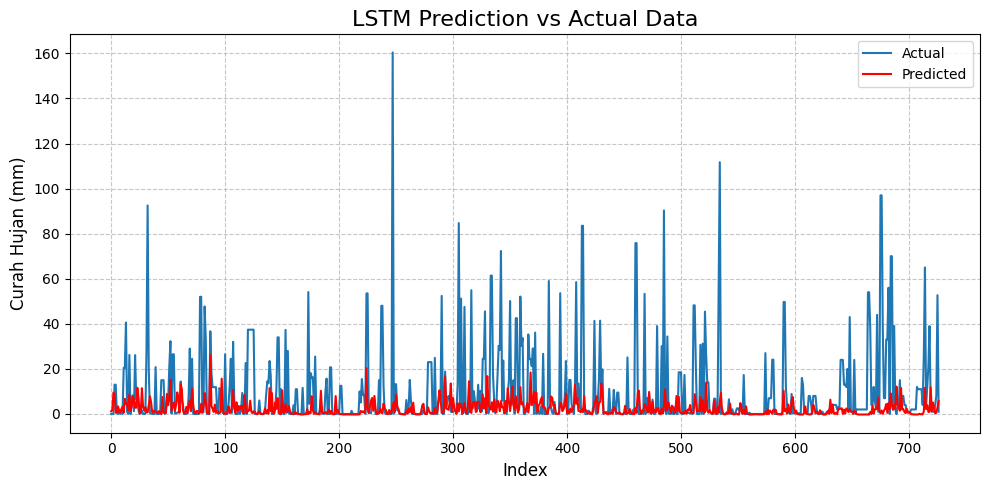

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_true, label='Actual')
plt.plot(y_test_pred, color='red', label='Predicted')
plt.title('LSTM Prediction vs Actual Data', fontsize=16)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Curah Hujan (mm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

# **Isolation Forest**

In [ ]:
# Model Isolation Forest
isolation_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05)
isolation_model.fit(y_pred.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [ ]:
# Prediksi anomali
anomaly_predictions = isolation_model.predict(y_pred.reshape(-1, 1))  # Jika -1: Anomali, 1: Normal
anomaly_scores = isolation_model.decision_function(y_pred.reshape(-1, 1))

In [ ]:
anomaly_indices = np.where(anomaly_predictions == -1)[0]
anomaly_indices = (anomaly_predictions == -1).sum()
total_data = len(anomaly_predictions)

print(f"Jumlah total data: {total_data}")
print(f"Jumlah anomali terdeteksi: {anomaly_indices}")
print(f"Persentase anomali: {anomaly_indices / total_data * 100:.2f}%")

Jumlah total data: 727
Jumlah anomali terdeteksi: 37
Persentase anomali: 5.09%


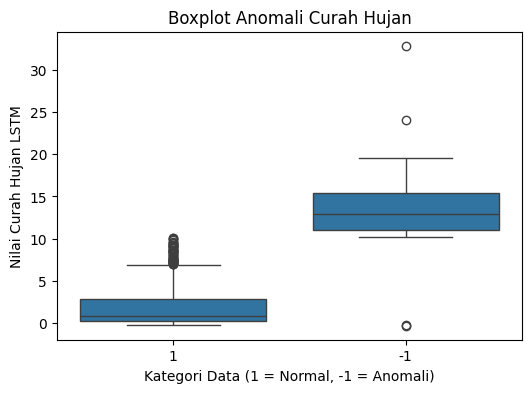

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=results_df['Anomali'].astype(str), y=results_df['Prediksi'])
plt.xlabel("Kategori Data (1 = Normal, -1 = Anomali)")
plt.ylabel("Nilai Curah Hujan LSTM")
plt.title("Boxplot Anomali Curah Hujan")
plt.show()

In [ ]:
# Pisahkan data berdasarkan kategori anomali
import scipy.stats as stats
anomali = results_df[results_df['Anomali'] == -1]['Anomali_Score']
normal = results_df[results_df['Anomali'] == 1]['Anomali_Score']

# Uji T-Test untuk dua kelompok
t_stat, p_value = stats.ttest_ind(normal, anomali)

# Cetak hasil
print(f"T-Statistic: {t_stat:.4-hf}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 28.6736
P-Value: 0.0000
